# [Computational Social Science]
## 5-2 Exploratory Data Analysis and Unsupervised Methods - Student Version

This lab will demonstrate some exploratory methods for finding separating words, and introduce unsupervised topic models.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [3]:
# download libraries
# ----------
!pip install scattertext
!pip install wordcloud
!pip install textblob

In [38]:
# load libraries
# ----------
import pandas as pd
import numpy as np
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

# code for kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# settings 
%matplotlib inline

## Data

<img src = "../../images/cfpb_logo.png"/>

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). This time, we are going to focus on figuring out whether we can find text features that help distinguish different "Products." There are several products represented in the dataset:

In [5]:
# load the data
# ----------

# load the dataframe
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")

# drop missing on "Consumer complaint narrative" feature and reset the index bc we've dropped
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])# not reseting the index here bc doing some other cleaning

# identify the unique characters is Product column
cfpb['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

For the first few exercises, we will focus on mortgages and student loans. We will also just use the first one thousand observations so that the code runs faster. 

In [6]:
# filter out only columns where product == "Mortgage" or "Student loan"
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]

# subset the first 1000 rows 
cfpb = cfpb[:1000]

In [7]:
# view 
# ----------
cfpb.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,NaN,Servicemember,Consent provided,Web,02/18/20,Closed with explanation,Yes,NaN,3502248
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,We purchased our house in XX/XX/XXXX the Assig...,NaN,Ocwen Financial Corporation,ID,NaN,NaN,Consent provided,Web,02/10/20,Closed with explanation,Yes,NaN,3497147
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,NaN,I had past issues with Mortgage Solutions of C...,NaN,MORTGAGE SOLUTIONS OF COLORADO,TX,NaN,Servicemember,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3583812
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,NaN,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,Servicemember,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586865
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,NaN,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,NaN,NaN,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3588118
397,04/01/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,"On XX/XX/2020, the CARES Act was signed into f...",NaN,AES/PHEAA,VA,223XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587932
403,04/02/20,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,- XX/XX/XXXX Got a letter my property taxes we...,Company believes complaint represents an oppor...,Ocwen Financial Corporation,WI,NaN,NaN,Consent provided,Web,04/02/20,Closed with explanation,Yes,NaN,3589531
407,04/03/20,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,XXXX XXXX Loan care servicing took over my loa...,Company has responded to the consumer and the ...,"LoanCare, LLC",GA,300XX,NaN,Consent provided,Web,04/03/20,Closed with explanation,Yes,NaN,3592305
490,03/03/20,Mortgage,FHA mortgage,Struggling to pay mortgage,NaN,Mr. XXXX provided a reinstatement quote in the...,Company has responded to the consumer and the ...,Freedom Mortgage Company,GA,303XX,NaN,Consent provided,Web,03/03/20,Closed with explanation,Yes,NaN,3552432
546,05/11/20,Mortgage,Home equity loan or line of credit (HELOC),Struggling to pay mortgage,NaN,Specialized Loan Servicing Crooks ... .. My hu...,Company has responded to the consumer and the ...,Specialized Loan Servicing Holdings LLC,TN,370XX,Older American,Consent provided,Web,05/11/20,Closed with explanation,Yes,NaN,3646965


## Preprocessing

Let's start by creating our tokens. We'll use the same `rem_punc_stop()` function we defined last time.

In [8]:
print(STOP_WORDS)

{'none', "'ll", 'give', 'per', 'using', 'whereby', 'becomes', 'together', 'part', 'everywhere', 'mine', 'ever', 'every', 'is', 'became', 'and', 'sometime', 'thence', 'show', 'through', 'enough', 'whole', 'put', 'formerly', 'in', 'now', 'former', 'within', 'never', 'hence', 'wherein', 'empty', 'n’t', 'somehow', 'about', 'for', 'there', 'a', 'along', 'after', 'even', 'nevertheless', 'one', 'of', 'towards', 'third', 're', 'anyway', 'might', 'out', 'whither', 'yet', '’s', 'call', 'been', 'should', 'n‘t', 'hereby', 'your', 'neither', 'upon', 'latterly', 'sixty', 'me', 'its', 'do', 'beside', 'rather', 'elsewhere', 'so', 'nor', 'but', '’m', 'among', 'herself', 'whereupon', 'down', 'say', 'fifteen', 'behind', 'thereafter', 'first', 'this', '’ve', 'above', 'were', 'further', 'whether', 'front', 'us', 'yourself', 'thereupon', 'across', 'over', 'these', 'be', 'such', 'around', 'keep', 'whose', 'very', 'at', 'top', 'already', 'could', 'i', 'below', 'ourselves', 'nine', 'perhaps', 'her', 'are', 'st

In [9]:
# create preprocessing function - just like we did in the last lab
# ----------
def rem_punc_stop(text):

    # set objects
    stop_words = STOP_WORDS         # set STOP_WORDS to a new object variable
    punc = set(punctuation)         # convert punctuation to a set
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_stop_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_stop_punc

Notice here how we use the `map()` function to apply our `rem_punc_stop()` function to every row of our dataframe. `map()` is typically much faster than writing a for loop, though there are also faster options like [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html) and vectorized numpy arrays.

In [10]:
# now apply the function to all the columns in our dataframe
# ----------
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x)) # can use apply here 
cfpb['tokens'] # visualize

213      [I, contacting, OCWEN, MORTGAGE, PHH, MORTGAGE...
216      [We, purchased, house, XXXXXXXX, Assignment, D...
283      [I, past, issues, Mortgage, Solutions, Colorad...
293      [I, called, Nationstar, multiple, times, reque...
387      [All, documents, short, sale, review, sent, XX...
                               ...                        
33836    [I, contacted, XXXX, XXXX, offering, complete,...
33855    [One, parent, plus, loan, opened, XXXXXXXX, ch...
33860    [TCF, refusing, provide, account, information,...
33880    [We, asking, loan, modification, years, In, pa...
33896    [loan, bayview, loan, services, went, 3,  , XX...
Name: tokens, Length: 1000, dtype: object

## Word Cloud

One of the most popular text analysis visualizations is the word cloud. Word clouds visualize the most frequent words in a corpus, and size them according to frequency.

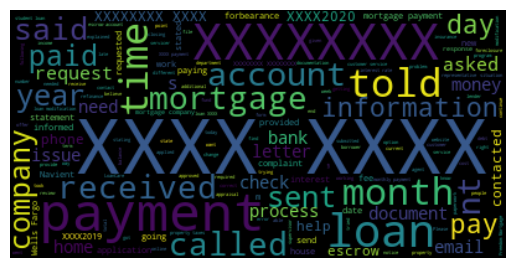

In [11]:
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text)

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

There are lots of ways to customize a word cloud, including by changing the background color:

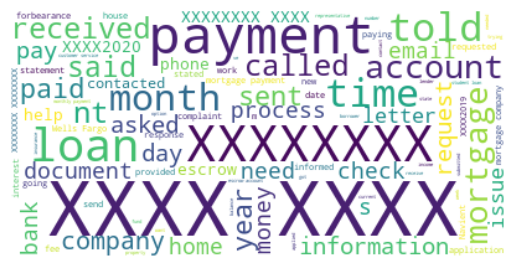

In [12]:
# same word cloud as above but changing background parameters
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = 'white',             # set background color to white
                      random_state=42  # set random state to ensure same word cloud each time
                      ).generate(text)           # change the background color



# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed 
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

And we can even overlay the wordcloud onto an image:

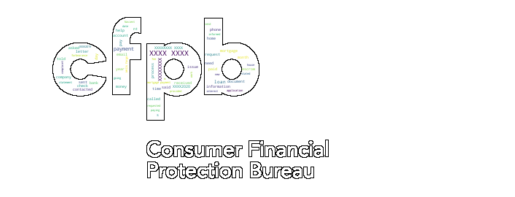

In [13]:
# spread the word cloud over the CFPB logo
# ----------
# load image
cfpb_mask = np.array(Image.open("../../images/cfpb_logo.png"))

# create word cloud
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# specify parameters of the wordcloud
wordcloud = WordCloud(background_color = 'white',                        # set background color to white
                      random_state= 10,           # set random state to ensure same word cloud each time
                      mask = cfpb_mask,          # mask is necessary 
                      contour_width=0.0001,      # provides an outline for clarity
                      width = 1000,
                      height = 1000).generate(text)

# plot 
plt.imshow(wordcloud,                   # specify wordcloud
           interpolation = 'bilinear')  # specifies how the words are displayed
plt.axis('off')                         # turn off axes
plt.show()                              # show the plot

### Challenge

Notice that in the above word clouds, tokens like "XXXX" and "XXXXXXXX" appear frequently. These are redacted dates and likely won't help us with classification. Try to rewrite `rem_punc_stop` to remove these.

**Hint**: Try taking a look at `nlp.Defaults.stop_words` and see if there are any associated methods that might help.

In [14]:
# rewrite the rem_punc_stop function to remove redacted account numbers (e.g, "XXX")
# ----------

def rem_punc_stop(text):
    stop_words = STOP_WORDS

    # add stop words
    nlp.Defaults.stop_words.update({'XX','XXXX','XXXXXXXX'})
    
    # convert punctuation to set
    punc = set(punctuation)
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

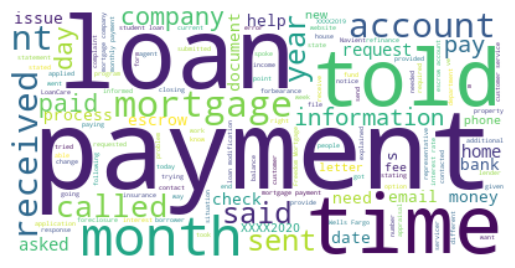

In [15]:
# recreate word cloud from above 
# ----------

# need to do preprocessing again and re-create "tokens" column
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = 'white',                    # specify white background
                     random_state=42         # set seeed
                     ).generate(text)         # generate from text dataset


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

**Bonus**: This is an example where using [regular expressions](https://docs.python.org/3/library/re.html) can be useful. Instead of inputting all of the different ways that something like "XX" might show up, you can use regex to find and remove all similar patterns.

## Lengths and Counts

One of the basic things we might look for when analyzing text data is the length of a document. Let's see how we might grab the total number of characters and the total number of words:

In [16]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
cfpb['complaint_len'] = cfpb['Consumer complaint narrative'].apply(len)

# count number of words
cfpb['word_count'] = cfpb['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

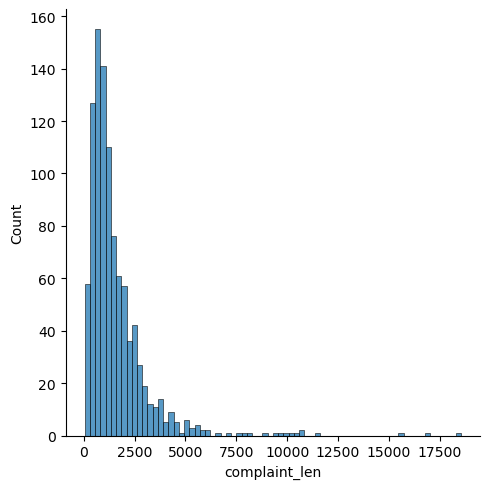

In [17]:
# create histogram of complaint length (number of characters)
sns.displot(cfpb,               # specify data
            x="complaint_len") # x-axis feature
plt.show()

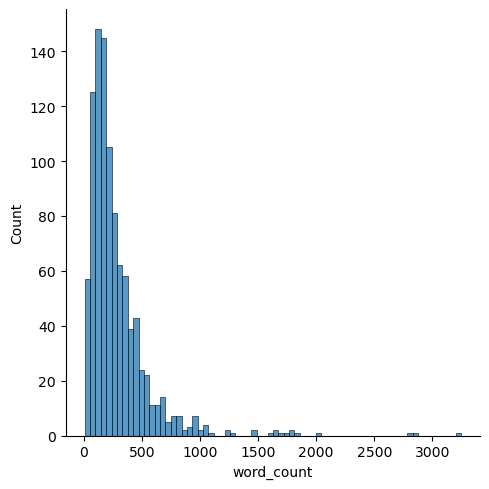

In [18]:
# create histogram of word count
sns.displot(cfpb,            # specify data
            x="word_count") # x-axis feature
plt.show()

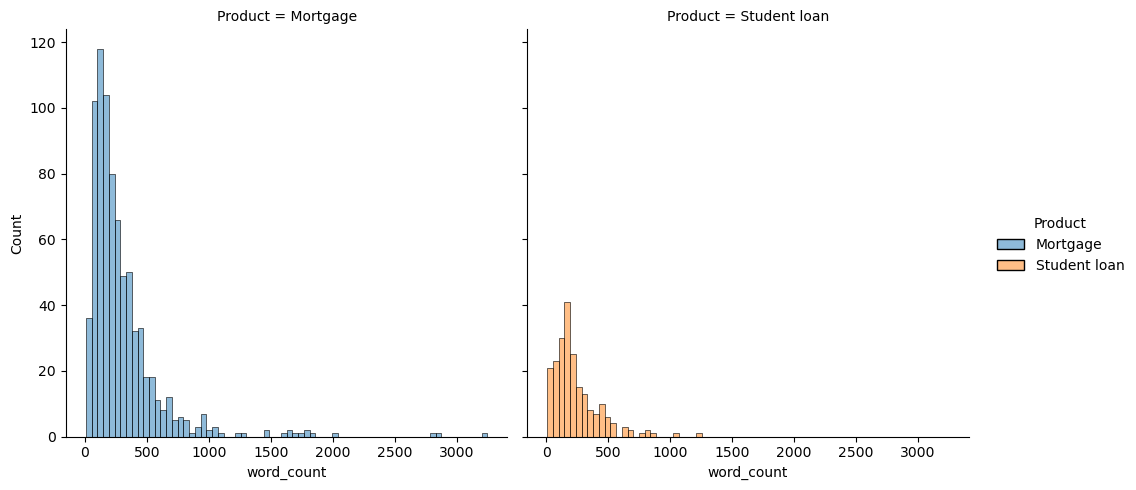

In [19]:
# histogram of word count by loan product 
sns.displot(cfpb,              # specify data
            x="word_count",   # x-axis feature
            hue = "Product",  # color by loan product
            col = "Product")  # color by loan product
plt.show()

## Sentiment Polarity

A common area of research in the social sciences is thinking about the "sentiment" of a text. The [`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html) library gives us access to a pre-trained sentiment analysis model. Text might be characterized as "positive," "negative," or "neutral" on a [-1,1] scale with -1 being highly negative and 1 being highly positive. Before we look at the code, do you expect that the sentiment scores for these data should be negative or positive? 

In [20]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again 
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,tokens,complaint_len,word_count,polarity
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,NaN,...,Web,02/18/20,Closed with explanation,Yes,NaN,3502248,I contacting OCWEN MORTGAGE PHH MORTGAGE AND a...,3075,552,0.122396
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,We purchased our house in XX/XX/XXXX the Assig...,NaN,Ocwen Financial Corporation,ID,NaN,...,Web,02/10/20,Closed with explanation,Yes,NaN,3497147,We purchased house Assignment Deed Trust signe...,308,55,0.092857
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,NaN,I had past issues with Mortgage Solutions of C...,NaN,MORTGAGE SOLUTIONS OF COLORADO,TX,NaN,...,Web,04/01/20,Closed with explanation,Yes,NaN,3583812,I past issues Mortgage Solutions Colorado LLC ...,889,154,0.151667
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,NaN,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,...,Web,03/31/20,Closed with explanation,Yes,NaN,3586865,I called Nationstar multiple times request upd...,654,121,0.050000
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,NaN,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,NaN,...,Web,03/31/20,Closed with explanation,Yes,NaN,3588118,All documents short sale review sent XXXX20 Sh...,1233,223,0.362500


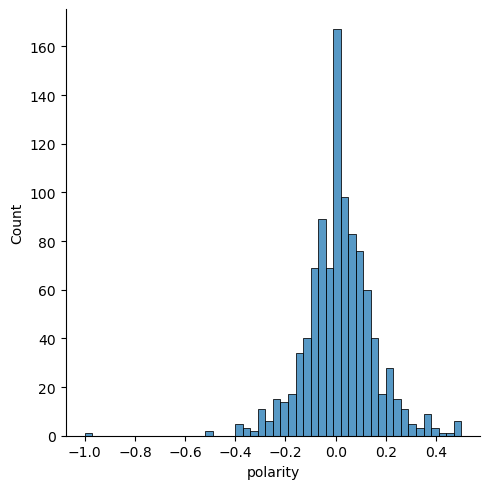

In [21]:
# histogram of polarity
sns.displot(cfpb,         # specify data
            x="polarity")     # x-axis label 
plt.show()

What's going on here? Why does sentiment look so close to neural, or even slightly positive? We know that all of the narratives in this dataset are consumer **complaints**, so we should expect them to look somewhat negative. Let's look at the 5 most positive reviews:

In [22]:
# loop to view the 5 most positive reviews
# ---------- 
for complaint in cfpb.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + "\n")

the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes

I paid my XXXX mortgage with Bayview Loan Servicing LLC. I have a confirmation number for my payment, and my payment came out of my bank account. My agent said that a mistake had been made and that my account had been sent to foreclosure, but he took my payment anyway. He assured me, though, that he would contact his supervisor and have the process halted. This morning a woman and knocked on my door saying she represented a third-party and that my home was in foreclosure and she was doing an occupancy check. I contacted XXXX XXXX. XXXX said that Bayview is in the business of foreclosing on homes. I want to be placed with a more reputable mortgage company. You can not eve

Do we have any words that are skewing things? Let's look at the sentiment score for this first comment, and the individual sentiments of the words in it:

In [23]:
sample_complaint = "I'm being charged for a loan when I told the university XXXX XXXX college that I would not be able to attend due to health crisis and I dropped out of the program yet they went ahead and processed the loan as if I never stopped attending. I was dismissed as nothing could be done but there seems to be something."

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  0.1875
I'm 0.0
being 0.0
charged 0.0
for 0.0
a 0.0
loan 0.0
when 0.0
I 0.0
told 0.0
the 0.0
university 0.0
XXXX 0.0
XXXX 0.0
college 0.0
that 0.0
I 0.0
would 0.0
not 0.0
be 0.0
able 0.5
to 0.0
attend 0.0
due -0.125
to 0.0
health 0.0
crisis 0.0
and 0.0
I 0.0
dropped 0.0
out 0.0
of 0.0
the 0.0
program 0.0
yet 0.0
they 0.0
went 0.0
ahead 0.0
and 0.0
processed 0.0
the 0.0
loan 0.0
as 0.0
if 0.0
I 0.0
never 0.0
stopped 0.0
attending. 0.0
I 0.0
was 0.0
dismissed 0.0
as 0.0
nothing 0.0
could 0.0
be 0.0
done 0.0
but 0.0
there 0.0
seems 0.0
to 0.0
be 0.0
something. 0.0


In [24]:
# focus on the first complaint and view its overall polarity 
# ---------- 
# create string capturing the first complaint above for analysis
sample_complaint = "the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes"

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  0.5
the 0.0
company 0.0
said 0.0
they 0.0
are 0.0
offering 0.0
a 0.0
covid 0.0
relief 0.0
program 0.0
which 0.0
I 0.0
requested 0.0
assistance 0.0
and 0.0
they 0.0
are 0.0
saying 0.0
a 0.0
balloon 0.0
payment 0.0
is 0.0
owed 0.0
in 0.0
XXXX 0.0
I 0.0
called 0.0
the 0.0
company 0.0
and 0.0
I 0.0
was 0.0
told 0.0
that 0.0
if 0.0
I 0.0
can't 0.0
make 0.0
this 0.0
payment 0.0
they 0.0
will 0.0
be 0.0
talking 0.0
taking 0.0
litigation 0.0
steps 0.0
how 0.0
are 0.0
people 0.0
who 0.0
have 0.0
lost 0.0
their 0.0
job 0.0
able 0.5
to 0.0
keep 0.0
their 0.0
homes 0.0


Only one word actually has a sentiment score ("able")! TextBlob's sentiment polarity is not a simple average of all of the sentiments in a string - this is why preprocessing is important and why you should validate these types of off-the-shelf methods. Let's take a look at the most negative reviews and see if these make sense:

In [25]:
# loop to view the 5 most negative reviews
# ---------- 
for complaint in cfpb.nsmallest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured.

I became ill last year and was unable to pay my mortgage because I was off from work. I have become delinquent and my home is set for a property foreclosure sale. I have requested mortgage assistance several times, the mortgage company has been difficult to work with me and refused to help me save my home

The company 1 file.org contacted me about student loan forgiveness. They charged me 3 payments of {$210.00} to process my paperwork and charged me a maintenance fee of {$29.00} XX/XX/XXXX, XX/XX/XXXX. I reached out to them in XX/XX/XXXX the phone number was no longer in business and no one never responded to my email. I am still unable to to find a contact for the business.

AmeriHome Mortgage is not refunding me my escrow money. I 

In [26]:
# focus on the first complaint and view its overall polarity 
# ---------- 
# create string capturing the first complaint above for analysis
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  -1.0
Navient 0.0
is 0.0
the 0.0
worst -1.0
company 0.0
to 0.0
ever 0.0
exist. 0.0
Website 0.0
does 0.0
not 0.0
work. 0.0
Do 0.0
the 0.0
people 0.0
at 0.0
customer 0.0
service 0.0
even 0.0
work 0.0
for 0.0
navient??? 0.0
They 0.0
don't 0.0
know 0.0
anything 0.0
about 0.0
whats 0.0
going 0.0
on. 0.0
Applied 0.0
for 0.0
a 0.0
repayement 0.0
plan 0.0
and 0.0
their 0.0
website 0.0
always 0.0
says 0.0
an 0.0
error 0.0
has 0.0
occured. 0.0


In this case we have a perfectly negative sentiment (-1.0), but again only one word is contirbuting - "worst". Sentiment polarity is a powerful tool, but not automatically suited to inference. That being said, maybe it can be helpful for distinguishing between labels. We can take a look at how polarity differs across mortgage and student loans. 

Is cutting the data this way helpful or not?

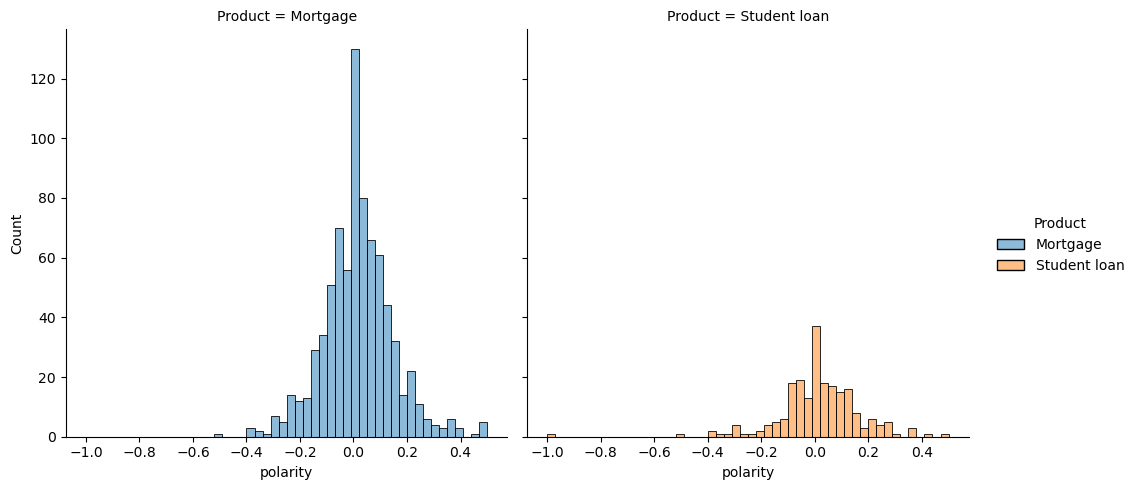

In [27]:
# histogram of polarity by loan product
sns.displot(cfpb,             # specify data
            x="polarity",    # specify x-axix feature 
            hue = "Product", # color by loan product
            col = "Product") # color by loan product
plt.show()

### Challenge

In addition to sentiment polarity, TextBlob also has a method for determining how "objective" or "subjective" a piece of text is. Plot the objectivity measure by loan product. Do these results make sense?

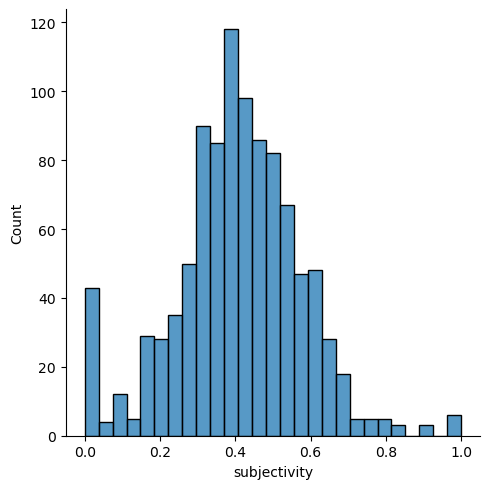

In [28]:
# create measure of subjectivity
# ---------- 

# create new column feature of subjectivity
cfpb['subjectivity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# plot
sns.displot(cfpb,
            x = 'subjectivity') 
plt.show()

In [29]:
for complaint in cfpb.nlargest(5, 'subjectivity')['Consumer complaint narrative']:
    print(complaint + "\n")

Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured.

Re ocwen loan XXXX I made my payments with Ocwen. Payments were missapplied. I called several times and was told there was no error. I finally reached a supervisor that said the matter was corrected. My bill was not correct for over four years. It was not corrected and an amount was demanded I did not owe and my house was placed in foreclosure. I tried several times but to no avail. I asked for a correct amount to pay and the amounts of money asked for the representatives could'nt justify.

I've had no money coming in since XX/XX/XXXX so I tried to get a mortgage payment forbearance for 3 months and my mortgage company M & T Bank will only defer me for 3 months and then they want all three payments at once The only way I could defer t

In [30]:
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."

# print polarity score
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.subjectivity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall polarity score is  1.0
Navient 0.0
is 0.0
the 0.0
worst 1.0
company 0.0
to 0.0
ever 0.0
exist. 0.0
Website 0.0
does 0.0
not 0.0
work. 0.0
Do 0.0
the 0.0
people 0.0
at 0.0
customer 0.0
service 0.0
even 0.0
work 0.0
for 0.0
navient??? 0.0
They 0.0
don't 0.0
know 0.0
anything 0.0
about 0.0
whats 0.0
going 0.0
on. 0.0
Applied 0.0
for 0.0
a 0.0
repayement 0.0
plan 0.0
and 0.0
their 0.0
website 0.0
always 0.0
says 0.0
an 0.0
error 0.0
has 0.0
occured. 0.0


**ANSWER**: ...

## ScatterText

Next we'll take a look at a useful visualization for finding separarting words. We'll use the [ScatterText](https://spacy.io/universe/project/scattertext) library to visualize both word frequencies and how well they separate two classes.

In [31]:
# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(cfpb[:5000],              # specify data
                             category_col = 'Product', # specify the explanatory variable  
                             text_col = 'tokens',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build

In [32]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Student loan',
                                       category_name='Student loan',
                                       not_category_name='Mortgage',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,
                                       metadata=cfpb['Complaint ID'])

In [33]:
# write html document to memory and open in browser
open("CFPB Sentiment.html", 'wb').write(html.encode('utf-8'))

2376792

## Unsupervised Methods

Finally, we'll look at unsupervised machine learning methods for text data. In this section, we'll implement K-means clustering algorithm, which is a simple and commonly used unsupervised machine learning methods, and [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), which is a classic method for topic modeling. 


In [34]:
# load and process data
# ---------- 
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000]

Let's start by creating our tf-idf matrix again. Note that this might take a bit because were are working with 1000 rows.

In [36]:
# create tf-idf matrix
# ----------
# set X dataset
X = cfpb['Consumer complaint narrative']        

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                     token_pattern = None)      # set to "None" since we have specify our own pattern

# fit and transform data
tfidf_matrix =  tf.fit_transform(X)

# create dense matrix to view
dense_matrix = tfidf_matrix.todense()
dense_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.03484747, 0.        , 0.07309592, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [56]:
# create a useful visualization of tf-idf matrix
# ----------

# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),      # convert to array than to datafram
                        columns=tf.get_feature_names_out())                   # specify column names as feature names 

# sort by term frequency on the first document
tfidf_df. T .nlargest(10,  # transpose the matrix and show just first 10 words 
                      0)   # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
lunch,0.411464,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
card,0.240613,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.106241,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.164657,0.078357,0.000000,0.0
loose,0.214806,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
180000,0.192943,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.094249,0.000000,0.0
worried,0.192943,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
170000,0.188080,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
reflecting,0.188080,0.0,0.000000,0.0,0.074316,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
nt,0.185289,0.0,0.080436,0.0,0.000000,0.060324,0.0,0.040907,0.220004,0.0,...,0.021026,0.035115,0.0,0.0,0.0,0.0,0.000000,0.150850,0.079167,0.0
break,0.183868,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
worry,0.176830,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


### K-Means

Now let's implement a simple kmeans clustering algorithim and add those labels (which cluster each record belongs to) back to our dataframe.

In [57]:
#
# K-means clustering
# ------------------------------

# implement kmeans clustering
# ----------
kmeans = KMeans(n_clusters = 3,                # specify 3 of clusters
                max_iter = 300                 # specify 300 of iterations
                ).fit(tfidf_matrix) # specify data to fit


# append labels to dataframe
# ----------
cfpb['cluster']= kmeans.labels_   # add labels to original data frame
cfpb.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,cluster
99,05/16/20,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,XXXX the XXXX I lost my card on a lunch run wh...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,750XX,NaN,Consent provided,Web,05/16/20,Closed with explanation,Yes,NaN,3655341,1
234,02/05/20,Checking or savings account,Checking account,Managing an account,Funds not handled or disbursed as instructed,In response to your answer dated XX/XX/XXXX. Y...,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,MO,658XX,Servicemember,Consent provided,Web,02/05/20,Closed with explanation,Yes,NaN,3521395,1
332,04/11/20,Checking or savings account,Other banking product or service,Opening an account,Confusing or missing disclosures,"On XX/XX/2020, my wife and I opened a business...",Company believes it acted appropriately as aut...,NAVY FEDERAL CREDIT UNION,FL,331XX,NaN,Consent provided,Web,04/11/20,Closed with explanation,Yes,NaN,3602599,1
346,04/01/20,Checking or savings account,Checking account,Opening an account,Didn't receive terms that were advertised,I signed up and opened a citibank checking acc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,606XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587986,1
397,04/01/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,"On XX/XX/2020, the CARES Act was signed into f...",NaN,AES/PHEAA,VA,223XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587932,2


#### Determining optiminal K: Elbow method

However, one of the key steps is to determine the optimal `k`. There are many ways to do this, but one approach is to iterate over a range of `k`s and use the elbow method to determine the best `k`.

The [elbow method](https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d) will calculate the *within-sum of squared distances* of every point from its respective cluster, and this will serve as a measure of compactness. We want that number to be smaller. A steep drop in WSS will create an elbow and indicates the appropriate number of clusters. However, remember this is **not always guaranteed.**

Let's see how we can implement this. **Describe what each line is doing:** 

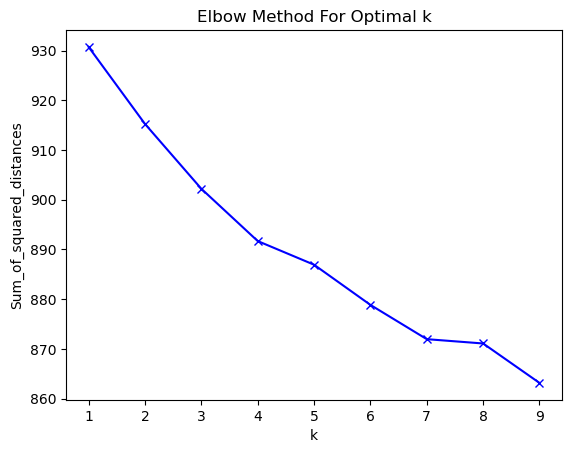

In [63]:
#
# determining optional k: elbow method
# ------------------------------

# settings
# ---------
# creating a list to store results
Sum_of_squared_distances = []

# try from 1 cluster to 9 clusters
K = range(1, 10) # second number is the ceiling of the range, but remember it is exclusive


# loop over k
# ---------
for k in K:
    # 
    km = KMeans(n_clusters=k,     #identify number of clusters 
                init='k-means++', #Method for initialization
                n_init=10,        #best results from 10 attempts
                random_state = 42)        
    #
    km = km.fit(tfidf_matrix)     # apply k-means to dataset; required input is a matrix

    # add results to the list
    Sum_of_squared_distances.append(km.inertia_)


# plot results
# ---------
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(range(1, max(K) + 1, 1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Determining optiminal K: silhouette scores

Another way to determine the optimal `k` is to compare silhouette scores across clusters. Again, there are many ways to do this, but one approach is to iterate over a range of `k`s and compare how far the score for each cluster deviates from the average across clusters. Then select the `k` where each cluster has a value closest to the  average. 

[Silhouette scores](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) quantify how close each point in a cluster is to points in the neighboring clusters and thus provide a way to assess parameters like number of clusters visually. They silhouette score will take a value on a range from -1 to 1, where scores near +1 indicate that the sample is far away from the neighboring clusters, 0 indicates a sample is on or very close to the decision boundary between two neighboring clusters, and negative -1 indicates that sample might have been assigned to the wrong cluster.


In [59]:
#
# determining optional k: silhouette scores
# ------------------------------
# define a number of functions

# iterate over a k-means fits to have different clusters
# ---------
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , random_state = 1)

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results


# calculate average silhouettes scores 
# ---------
# plot silhouettes scores
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

# plot silhouettes scores       
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg): 
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])   # play with this to set x-axis limits
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
# put it altogether
def silhouette(kmeans_dict, df, plot=True):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

**QUESTION:** What do we think about the fit? Are we happy with any set number of clusters?

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


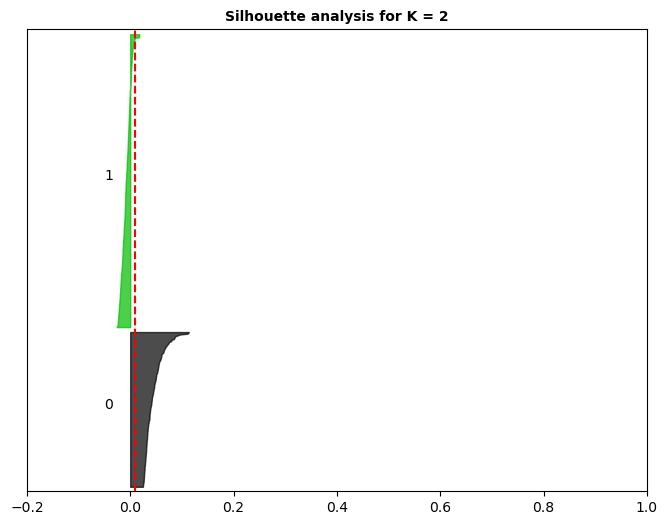

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


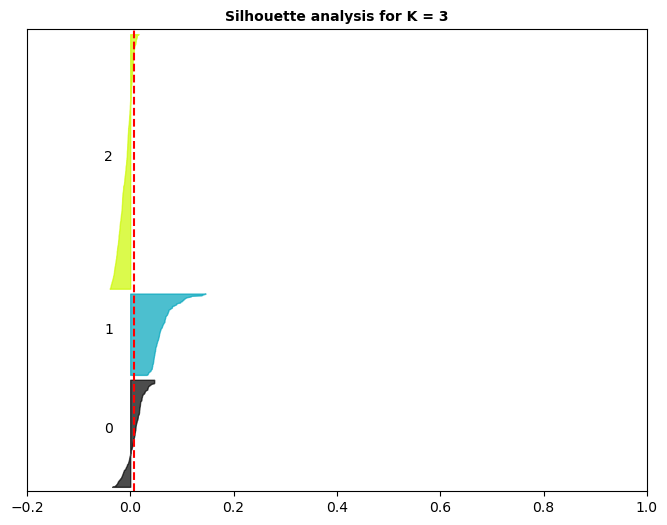

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


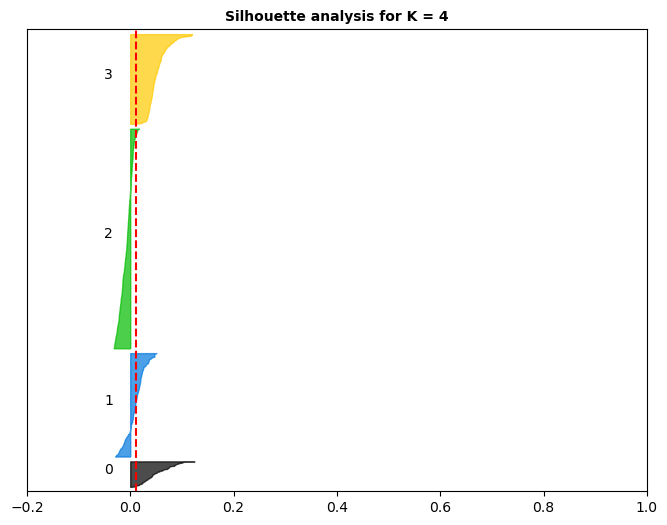

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


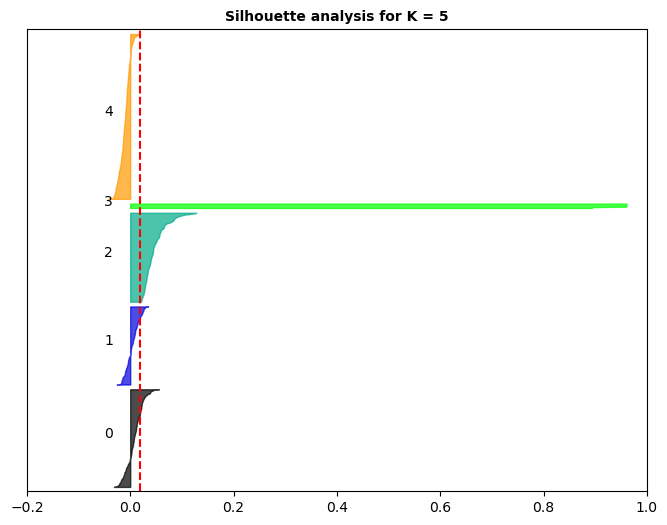

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


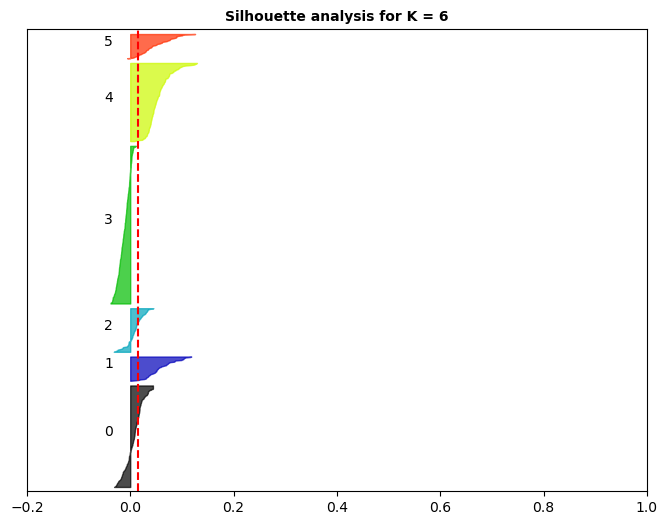

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


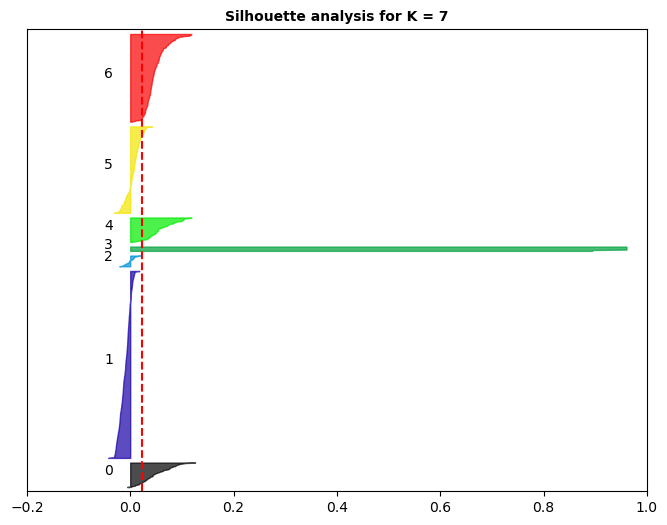

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


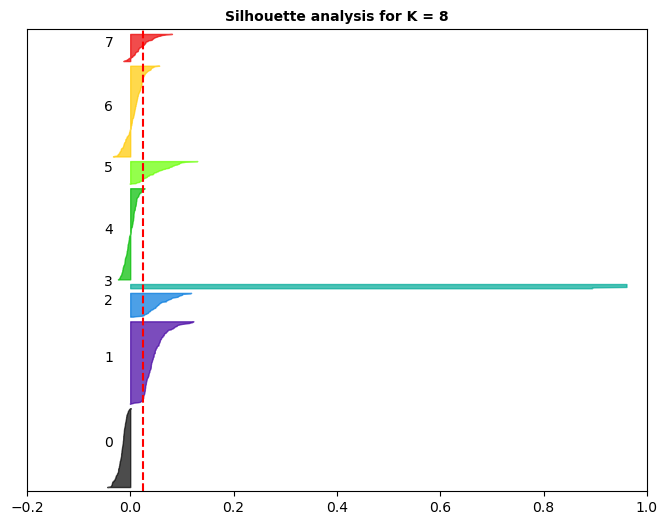

In [60]:
#
# calculate silhouette scores across potential k-means clusters 
# ---------

# set K
k = 8 # choose 8 based on the elbow method result from above

# run the k-means algorithm
kmeans_results = run_KMeans(k,                # set k
                            data = tfidf_df)  # identify data


# plot the silhouette analysis
silhouette(kmeans_results,     # take k-means results
           tfidf_df)           # use the dataframe version

**ANSWER:**  Based on the results from the silhouette scores analysis, there does not seem to be an optimal number of clusters that fit the data well in their current form. A k-means clustering fit would likely perform better after more some more cleaning (removing more unhelpful words) or a rethinking of the dataset (perhaps there is no clear distinction between student loans and mortgage complaints using bag-of-word structured analysis. 

#### Cluster analysis of top words

Still, we might want to evaluate some of the top words in each cluster to confirm k-means is not a good approach here or to validate when it indeed is. We can write a function to iterate over the clusters and pull the top word. 

In [64]:
#
# cluster analysis of top words in each cluster
# ------------------------------

# create functions
# ---------

# get the top features from each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

# plot them on a barplot
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

**QUESTION:** Do these word plots give us any insight into why these k-means models are not performing well?

In [49]:
# run k-means and visualize word count
# ---------

# get results from 5 clusters 
best_result = 5
kmeans = kmeans_results.get(best_result)

# processing for plot
tfidf_array = tfidf_df.to_numpy()     # convert dataframe to array
prediction = kmeans.predict(tfidf_df) # predict cluster using tf-idf dataframe


# plot
n_feats = 20
dfs = get_top_features_cluster(tfidf_array, # specify dataset which is an array
                               prediction,  # make specify prediciton
                               n_feats )    # set number of features 
plotWords(dfs, # specify data for plotting  
          13)  # set number of features

NameError: name 'kmeans_results' is not defined

**ANSWER:** If we look back at the `tfidf_df`, we can see a number of paragraph separators (`\n`) that seem to remain in the documents, it is likely host black spaces that are showing up here, and would be one thing that might improve fit if we were to remove them. 

### Latent Dirichlet Allocation (LDA)


Now, let's turn to LDA. Remember, like other unsupervised machine learning models, topic models can help us uncover structure within a text. It does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document. 

Let that we have a tf-idf matrix, let's apply our LDA model. The key hyperparameter here is the `n_components` argument. Let's start with 5, and then print out our topics to see what we get.

In [65]:
#
# Fitting a Latent Dirichlet Allocation model 
# ------------------------------

# initialize LDA model 
# ---------- 
lda = LatentDirichletAllocation(n_components = 5,              # set # of components to 5
                                max_iter = 20,              # specify 20 max iterations
                                random_state=0)   # set seed for reproducibility

# fit LDA to data
# ---------- 
lda = lda.fit(tfidf_matrix)  # use the sparse matrix created above 
lda

LatentDirichletAllocation(max_iter=20, n_components=5, random_state=0)

In [66]:
# define a function to get and view top words for each topic
# ---------- 
def print_top_words(model, feature_names, n_top_words):    # define function and parameters
    for topic_idx, topic in enumerate(model.components_):  # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))            # print topic index
        print(" ".join([feature_names[i]                   # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [67]:
# get feature names from tf-idf matrices 
# ---------- 
tf_feature_names = tf.get_feature_names_out()   # get feature names


# apply function to print top words
print_top_words(lda,                # model 
                tf_feature_names,   # feature names 
                20)                # top 20 words


Topic #0:
xxxx1989 acccounts divided compromised 4x keybank disaster multiple science consistency amortization bribes trump natural rting nonlicensed loved vacated yrump xxxxpd

Topic #1:
forebearances immoral structuring misconduct accountwithout lousy corporations punish crooked officers decreased 1999 9r sson sensitive reconcile informationi bankin matteri reportson

Topic #2:
xxxx   account bank xxxxxxxx 

 loan money nt check told 
 loans payment card funds called received xxxx2020 payments

Topic #3:
ameritech courtesy acs deeper pod wrongfully 4600 pymt warnings wrongdoings alliant voted trial negatives amt certificates conduet thrown plunges dip

Topic #4:
credit lately relation days60 aforesaid misreport tuned prefer unfavorable days120 recommend generate particular seriously highly accordance greatly item present regulations



We have 5 topics! Some seem to be sensible (i.e. Topic #1 seems to be about banking attitudes while Topic #2 is about loans payments), but notice that the computer doesn't provide a "topic name" for us automatically, so there is still a role for humans to interpret and make sense of the output.

#### Topic weights

One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the `pandas` dataframe.

Let's first get the topic distribution array.

In [68]:
# calculate topic weights from distribution 
# ----------
topic_dist = lda.transform(tfidf_matrix) # calculate distribution of topics for each document in the corpus 
topic_dist  # note that this output is an array

array([[0.02775814, 0.02775816, 0.88895863, 0.02775812, 0.02776695],
       [0.02771652, 0.02771655, 0.88902321, 0.02771649, 0.02782722],
       [0.03656152, 0.0365615 , 0.85351996, 0.03656152, 0.0367955 ],
       ...,
       [0.0212155 , 0.02121548, 0.9151342 , 0.02121541, 0.02121942],
       [0.022549  , 0.02254905, 0.90975659, 0.02254896, 0.0225964 ],
       [0.03473878, 0.03473879, 0.86095823, 0.03473877, 0.03482543]])

And then we'll merge back with original dataframe:

In [69]:
# convert topic distribution array to pandas dataframe
# ----------
topic_dist_df = pd.DataFrame(topic_dist)

# join back to pandas dataframe and reset index
df_w_topics = topic_dist_df.join(cfpb.reset_index())

# view
df_w_topics.head() # notice that the topic distribution is the first 5 columns

,0,1,2,3,4,index,Date received,Product,Sub-product,Issue,...,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,cluster
0,0.027758,0.027758,0.888959,0.027758,0.027767,99,05/16/20,Checking or savings account,Checking account,Managing an account,...,750XX,NaN,Consent provided,Web,05/16/20,Closed with explanation,Yes,NaN,3655341,1
1,0.027717,0.027717,0.889023,0.027716,0.027827,234,02/05/20,Checking or savings account,Checking account,Managing an account,...,658XX,Servicemember,Consent provided,Web,02/05/20,Closed with explanation,Yes,NaN,3521395,1
2,0.036562,0.036562,0.853520,0.036562,0.036795,332,04/11/20,Checking or savings account,Other banking product or service,Opening an account,...,331XX,NaN,Consent provided,Web,04/11/20,Closed with explanation,Yes,NaN,3602599,1
3,0.033611,0.033611,0.865517,0.033611,0.033650,346,04/01/20,Checking or savings account,Checking account,Opening an account,...,606XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587986,1
4,0.022410,0.022410,0.910326,0.022410,0.022444,397,04/01/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,...,223XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587932,2


Now we can check the average weight of each topic across loan product using `groupby`.

In [70]:
# group by loan products and calculate mean
# ----------

# group the topds
grouped = df_w_topics.groupby('Product')

# loop over the dataframe and calculate mean
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

Product
Checking or savings account    0.030542
Student loan                   0.029526
Name: 0, dtype: float64
Product
Checking or savings account    0.029730
Student loan                   0.028661
Name: 1, dtype: float64
Product
Checking or savings account    0.878848
Student loan                   0.849185
Name: 2, dtype: float64
Product
Student loan                   0.030433
Checking or savings account    0.029806
Name: 3, dtype: float64
Product
Student loan                   0.062195
Checking or savings account    0.031074
Name: 4, dtype: float64


None of the topics seem to have much separation, but let's visualize topics 2 and 3 to be sure.

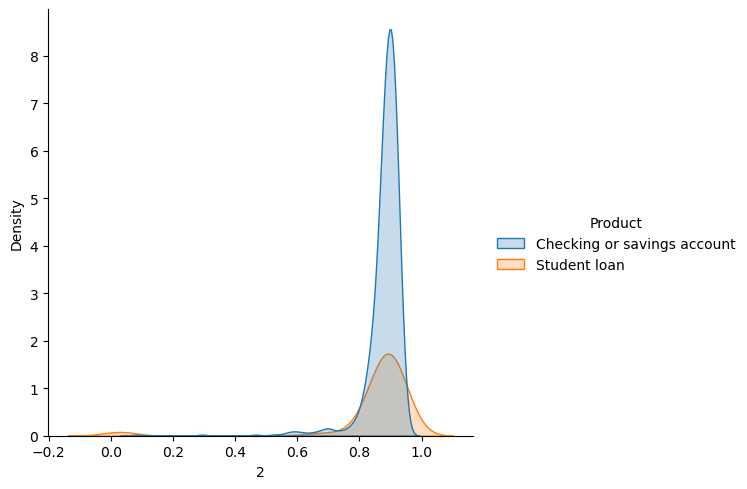

In [71]:
# histogram of topic 2
# ----------
sns.displot(df_w_topics,      # data
            x=df_w_topics[2], # x-axis feature subet to only topic 2
            hue = "Product",  # by loan product
            kind = 'kde',     # specify kdensity plot
            fill = 'true')    # fill
plt.show()

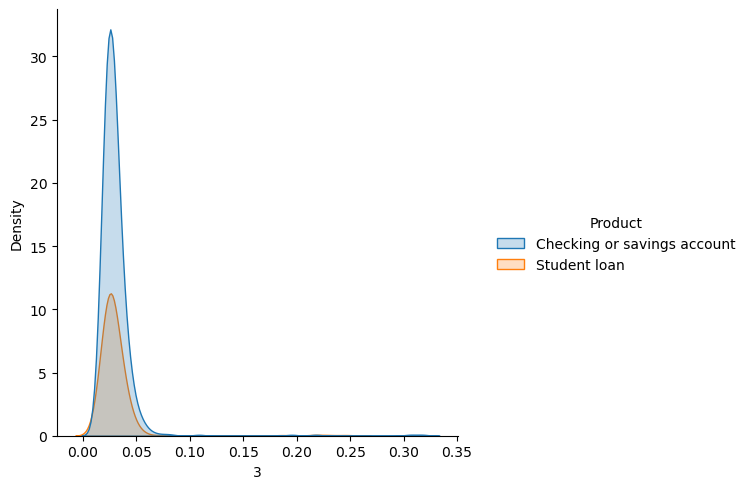

In [72]:
# histogram of topic 3
# ----------
sns.displot(df_w_topics,      # data
            x=df_w_topics[3], # x-axis feature subet to only topic 2
            hue = "Product",  # by loan product
            kind = 'kde',     # specify kdensity plot
            fill = 'true')    # fill
plt.show()

Unsurprisingly, there doesn't seem to be very much separation between the two topics given that we didn't see much separation between the means above.

### Challenge

Try retraining the LDA with a different number of topics, for example, try 10. 


**QUESTION:** What do you notice? How is this similar to issues we've seen with other clustering algorithms?

In [ ]:
# LDA - 10 topics instead
# ---------- 

# initialize LDA model 
lda = LatentDirichletAllocation(...,             # specify 10 components
                                ...,             # set max iter to 20
                                random_state=0)  # set random seed


# fit LDA to data
lda = lda.fit(...) # specify a matrix input

# define a function to get and view top words for each topic
def print_top_words(model, feature_names, n_top_words):   # define function and parameters
    for topic_idx, topic in enumerate(model.components_): # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))           # print topic index
        print(" ".join([feature_names[i]                  # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# get feature names from tf-idf matrices 
tf_feature_names = tf. ...()

# apply function to print top 20 words
print_top_words(...,   # model 
                ...,   # feature names 
                ...)   # number of top words

**ANSWER**: ...

---
Notebook developed by Aniket Kesari. Modified by Prashant Sharma (2023) and annotated by Kasey Zapatka (2024).